# エッジ検出を使ってサムネイルに適した切り抜きをする

エッジ検出にはAKAZEを用いる。

縦横のうち短い方に合わせて正方形で切り取ることを考える

In [22]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

In [23]:
#前処理リサイズ後の横幅
resized_w=150
#切り抜きバウンディングボックスのずらし幅
d=10

def resize(img):
    scale  = resized_w/img.shape[1]
    return cv2.resize(img, dsize=None, fx=scale, fy=scale,interpolation=cv2.INTER_LINEAR)

def show(img):
    cv2.imshow('image',img)
    cv2.waitKey(0)
    
def show_inline(img):
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
def img_from_file(file):
    img=cv2.imread(file)
    transposed=img.shape[0]<img.shape[1]
    if transposed:
        img=img.transpose(1,0,2)
    return resize(img),transposed

def detect_edges(img,akaze):
    kp,des= akaze.detectAndCompute(img, None)
    for k in kp:
        cv2.circle(img, (int(k.pt[0]),int(k.pt[1])), 1, (0,0,255), -1)
    return kp

def crop(img,kps):
    w=resized_w//d
    h=img.shape[0]//d+1
    count=np.zeros((h,w))
    for kp in kps:
        count[int(kp.pt[1])//d][int(kp.pt[0])//d]+=1
    count=count/count.max()*255
    sal=img.copy()
    for i in range(h):
        for j in range(w):
            sal = cv2.rectangle(sal,(j*d,i*d),((j+1)*d,(i+1)*d),(0,0,count[i][j]),-1)
    maxj=0
    crop_h=w//2
    cost=sum(sum(count[j:j+crop_h]))
    max_cost=cost
    for j in range(h-crop_h):
        cost=cost-sum(count[j])+sum(count[j+crop_h])
        if cost>max_cost:
            maxj=j+1
            max_cost=cost
    maxj=min(max(0,maxj-w//4),h-w)
    return sal,(maxj*d,(maxj+w)*d)

def draw_bounding_box(img,akaze):
    kps=detect_edges(img,akaze)
    sal,bounds=crop(img,kps)
    return sal,cv2.rectangle(img,(0,bounds[0]),(img.shape[0],bounds[1]),(0,0,255),2)

# 実行

赤枠は切り抜き枠

赤点は検出されたエッジ

下の画像は10×10の格子ごとのエッジの数を赤の濃さで表す

Wall time: 12 ms


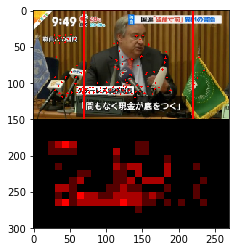

In [24]:
files = glob.glob('hasan.jpg')
akaze = cv2.AKAZE_create()
akaze.setThreshold(0.001)
akaze.setNOctaves(4)
for file in files:
    img,transposed=img_from_file(file)
    %time sal, bounded=draw_bounding_box(img,akaze)
    if transposed:
        sal=sal.transpose(1,0,2) 
        bounded=bounded.transpose(1,0,2)
    show_inline(cv2.vconcat([bounded,sal]))